# NLP for Sentiment Analysis of Movie Reviews

The idea is to take text $X$ and return a label $yhat$.
Sentiment
* 1 is positive
* -1 is negative
* 0 is neutral

Notebook followed from Joseph Santarcangelo: Skills Network


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from scipy.sparse import dok_matrix

# For suppresssing warnings
def warn(*args, **kwargs):
  pass

import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')
warn()

### Helper functions

In [2]:
def print_sample_and_class(data, class_ = 1, n_samples = 5):
  """
  Prints the class and document the dataframe
  """
  index = data[data['y'] == class_]['X'].index[0:n_samples]

  for i in index:
    print(f"sample {i} of class {class_}")
    print(data[data['y'] == class_]['X'][i])

#### Load data

In [3]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX08RAEN/sentiment-text-threeclass/train.txt",header=None, sep="\\|\\|\\|",names=['y','X'])
df.head()

,y,X
0,1,The Rock is destined to be the 21st Century '...
1,1,The gorgeously elaborate continuation of `` T...
2,1,Singer\/composer Bryan Adams contributes a sl...
3,0,You 'd think by now America would have had en...
4,1,Yet the act is still charming here .


"1" if the sentiment of the text is positive

"-1" if the sentiment of the text is negative

"0" for neutral

In [4]:
# Prints 5 samples from the dataframe from sentiment being 1
print_sample_and_class(df, class_=1,n_samples=5)

sample 0 of class 1
 The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
sample 1 of class 1
 The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .
sample 2 of class 1
 Singer\/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .
sample 4 of class 1
 Yet the act is still charming here .
sample 5 of class 1
 Whether or not you 're enlightened by any of Derrida 's lectures on `` the other '' and `` the self , '' Derrida is an undeniably fascinating and playful fellow .


In [6]:
# Each sample is a string
my_string=df['X'][0]
print("document:",my_string)
print("\n type:",type(my_string))

document:  The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .

 type: <class 'str'>


In [7]:
# First 10 characters of the string
my_string[0:10]

' The Rock '

In [8]:
# Split the string into individual tokens/words
my_string.split()

['The',
 'Rock',
 'is',
 'destined',
 'to',
 'be',
 'the',
 '21st',
 'Century',
 "'s",
 'new',
 '``',
 'Conan',
 "''",
 'and',
 'that',
 'he',
 "'s",
 'going',
 'to',
 'make',
 'a',
 'splash',
 'even',
 'greater',
 'than',
 'Arnold',
 'Schwarzenegger',
 ',',
 'Jean-Claud',
 'Van',
 'Damme',
 'or',
 'Steven',
 'Segal',
 '.']

In [9]:
# Convert each token to lowercase
my_string.casefold()

" the rock is destined to be the 21st century 's new `` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal ."

In [10]:
# Conver each token in each column to lowercase
df["X"].str.casefold()

,X
0,the rock is destined to be the 21st century '...
1,the gorgeously elaborate continuation of `` t...
2,singer\/composer bryan adams contributes a sl...
3,you 'd think by now america would have had en...
4,yet the act is still charming here .
...,...
8539,a real snooze .
8540,no surprises .
8541,we 've seen the hippie-turned-yuppie plot bef...
8542,her fans walked out muttering words like `` h...


In [11]:
# Count 'good' and 'bad' words
good_words = ['love', 'good', 'excellent', 'great', 'charming']

bad_words = ['hate', 'bad', 'brutal', 'damnable', 'deplorable', 'detestable',
             'disastrous', 'dreadful']

In [12]:
# We assign a 1 to positive word, -1 to negative word, then calculate the total
df['score'] = 0
for bad_word in bad_words:
  df['score'] -= df['X'].str.casefold().str.count(bad_word)

In [13]:
for good_words in good_words:
    df["score"]+=df["X"].str.casefold().str.count(good_words)

In [14]:
df.head()

,y,X,score
0,1,The Rock is destined to be the 21st Century '...,1
1,1,The gorgeously elaborate continuation of `` T...,0
2,1,Singer\/composer Bryan Adams contributes a sl...,0
3,0,You 'd think by now America would have had en...,0
4,1,Yet the act is still charming here .,1


In [15]:
# Highest score
df.loc[df["score"].argmax(axis=0),'X']

' Good fun , good action , good acting , good dialogue , good pace , good cinematography .'

In [16]:
# Lowest score
df.loc[df["score"].argmin(axis=0),'X']

' It is that rare combination of bad writing , bad direction and bad acting -- the trifecta of badness .'

,score
y,
-1,"Axes(0.125,0.11;0.775x0.77)"
0,"Axes(0.125,0.11;0.775x0.77)"
1,"Axes(0.125,0.11;0.775x0.77)"


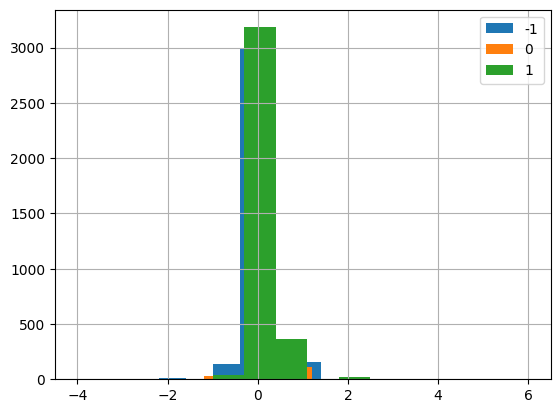

In [21]:
# Calculate score for positive, negative, and neutral classes
df[["score","y"]].groupby('y')["score"].hist(legend=True)

In [22]:
# Create new column 'yhat' for the neutrals
df['yhat']=0

In [23]:
# Simple rule based-thresholds
negative_label = df[['score']].sum(axis = 1) < 1
pos_label = df[['score']].sum(axis = 1) > -1

In [24]:
# Assign the class according to the score
df['yhat'][negative_label] = -1
df['yhat'][pos_label] = 1

In [25]:
df['y'].value_counts()

,count
y,
1,3610
-1,3310
0,1624


In [26]:
# Compare the predicted sentiment with the actual sentiment
np.mean(df['yhat'] == df['y'])

0.43562734082397003

We see that the accuracy is not very good.

Reasons why the rule-based classifier did not perform well:

Limited word list:

The word list was small, while datasets can contain thousands of positive and negative words.
No neutral words were included.
Simplistic scoring method:

Positive words were assigned a score of 1, and negative words a score of -1.
Some words might need stronger weights, e.g.,
Positive examples:
"Amazing" should have a score of 10.
"Ok" might have a score of 4.
Negative examples:
"Barfed" could have a score of -10.
"Boring" might have a score of -4.
Contextual inaccuracies:

Some neutral or negative words might carry positive sentiment in certain contexts, and vice versa.

## Multi-class logistic regression

To improve the accuracy, we will use multi-class logistic regression.

In [27]:
train_dataset=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX08RAEN/sentiment-text-threeclass/train.txt",header=None, sep="\\|\\|\\|",names=['y','X'])
validation_dataset=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX08RAEN/sentiment-text-threeclass/dev.txt",header=None, sep="\\|\\|\\|",names=['y','X'])
test_dataset =pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX08RAEN/sentiment-text-threeclass/test.txt",header=None, sep="\\|\\|\\|",names=['y','X'])

#### Features

We transform our content into numbers, we denote features for $n$th document with the feature vector $x_{n}$. The $i$th word would be the $i$th element in $x_{n}$ denoted by $x_{i}$.

### Bag-of-Words

BoW model transforms text into fixed-length vectors.
 using CountVectorizer. It converts a set of text documents to a matrix of token counts called a document-term matrix (TDM). The TDM is a sparse matrix object scipy.sparse.csr_matrix where each row represents a different document, and each column represents each word in the document. For each element in the matrix, it represents how many times that word occurs.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

#### Simple Example for Exploration

In [29]:
corpus = [
    'This is the first of document .',
    'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?' ]

In [30]:
# Apply CountVectorizer
vectorizer = CountVectorizer()

X_toy = vectorizer.fit_transform(corpus)
X_toy

<4x10 sparse matrix of type '<class 'numpy.int64'>'
	with 22 stored elements in Compressed Sparse Row format>

In [38]:
# Output the word corresponding to each column
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'of', 'one', 'second', 'the',
       'third', 'this'], dtype=object)

In [39]:
# As np.array
X_toy.toarray()

array([[0, 1, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 1]])

In [41]:
# Convert the output to a dataframe. We see the word corresponding to each column and the phrase for each row
original_toy_df= pd.DataFrame(X_toy.toarray(),columns=vectorizer.get_feature_names_out(),index=corpus )
original_toy_df

,and,document,first,is,of,one,second,the,third,this
This is the first of document .,0,1,1,1,1,0,0,1,0,1
This document is the second document.,0,2,0,1,0,0,1,1,0,1
And this is the third one.,1,0,0,1,0,1,0,1,1,1
Is this the first document?,0,1,1,1,0,0,0,1,0,1


For the first document  'This is the first of document .'  would have the featuer $\mathbf{x}_1=[0, 1, 1, 1, 1, 0, 0, 1, 0, 1]$, the second document would be $\mathbf{x}_2=[0, 2, 0, 1, 0, 0, 1, 1, 0, 1]$ and do on

### Training a Model with Grid Search and Logistic Regression

Determine hyperparameters automatically using ```GridSearchCV```

In [42]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [43]:
dataset=pd.concat([train_dataset,validation_dataset],axis=0)

We can keep track of what samples belong to training a validation by creating a NumPy array where negative ones correspond to training samples, and zeros correspond to validation data. We then use  a predefined scheme using ```PredefinedSplit``` .


In [44]:
from sklearn.model_selection import PredefinedSplit

split_index = [-1]* train_dataset.shape[0] + [0] * validation_dataset.shape[0]
pds = PredefinedSplit(test_fold = split_index)

In [45]:
# Transform the dataset

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(dataset['X'])
y=dataset['y']

In [46]:
# Transform the test dataset
X_test=vectorizer.transform(test_dataset['X'])
y_test=test_dataset[['y']]

We create a dictionary of hyperparameters, the Inverse of regularization strength; and the norm of the penalty. We assume L1 would be better as the data is sparse:

In [47]:
param_grid = {'penalty' : ['l1', 'l2'],'C' : np.logspace(-4, 4, 20)}

We create a `GridSearchCV` object with a logistic regression estimator. The `cv` parameter specifies the cross-validation splitting strategy, and we use the predefined split. Finally, we apply the parameter grid defined earlier.

In [48]:
clf = GridSearchCV(estimator = LogisticRegression(),cv=pds,param_grid=param_grid)
clf

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [49]:
# Fit the model and print out the highest-accuracy in the validation data and corresponding best parameter
clf.fit(X, y)
print("highest accuracy in the validation accuracy ",clf.best_score_)
print("best hyperparameters:",clf.best_params_)


highest accuracy in the validation accuracy  0.6185286103542235
best hyperparameters: {'C': 0.23357214690901212, 'penalty': 'l2'}


In [50]:
# Calculate the accuracy

print(" best parameters accuracy score :",clf.score(X_test,y_test))

 best parameters accuracy score : 0.6506787330316742


In [51]:
# Find the best model
model=clf.best_estimator_

In [52]:
# Make prediction

model.predict(X_test)

array([ 0,  1,  1, ...,  1, -1, -1])

Note: The logistic regression is calculating the score using parameters  $w_{ij}$ for the $j$ class

$s_j= \sum_{i=1}^{N} w_{ij}x_i$

The larger \( s_j \), the higher the score, and more likely that the sample belongs to that class. Since \( x_i \) is typically one, a significant \( w_{ij} \) suggests that the word is more likely to contribute to that class. Conversely, if \( w_{ij} \) is negative, the word is less likely to belong to that class.

In [54]:
# Determine the words with the largest parameters or score
feature_importance=np.argsort(model.coef_)
feature_importance

array([[13154, 10758,  4739, ..., 13754,  4380, 16007],
       [ 9787, 12377,  7071, ...,  8854,  3286,  5887],
       [ 4380, 13852, 16007, ..., 11632, 11532,  4772]])

In [58]:
#Find the corresponding vector $x_{i}$ and then using
# get_feature_names_out() to find the word with the highest score
for class_ in range(3):

    print("(j) or y=",class_)
    print(np.array(vectorizer.get_feature_names_out())[feature_importance[class_,0:10]])


(j) or y= 0
['solid' 'powerful' 'enjoyable' 'best' 'hilarious' 'fun' 'perfectly'
 'charming' 'always' 'human']
(j) or y= 1
['offers' 'screen' 'imagine' 'thoroughly' 'crafted' 'impressive'
 'frequently' 'going' 'watching' 'four']
(j) or y= 2
['dull' 'suffers' 'worst' 'mess' 'too' 'unfortunately' 'lack' 'less'
 'plain' 'bad']


In [60]:
def build_feature_map(X):
  '''
  Create CountVectorizer function
  '''
  word_types = set()
  # Split string into words using split()
  for x in X.str.casefold().str.split().apply(set):

    word_types = word_types.union(x)

    # Create a dictionary by word mapping to index
    return {word: idx for idx, word in enumerate(word_types)}

word_to_idx = build_feature_map(train_dataset["X"])

In [61]:
def extract_features(word_to_idx: dict, X: np.ndarray) -> dok_matrix:
    """
    Extracts features from the input text dataset by creating a document-term matrix.

    Parameters:
    - word_to_idx (dict): A mapping from words to their corresponding indices.
    - X (np.ndarray): Array of text documents.

    Returns:
    - dok_matrix: A sparse matrix representing the document-term frequency features.
    """
    D = len(word_to_idx)  # Number of unique words in the vocabulary
    N = X.shape[0]        # Number of documents in the dataset
    words = set(word_to_idx.keys())  # Set of words for quick lookup

    # Initialize a sparse matrix in DOK format (efficient for incremental updates)
    features = dok_matrix((N, D), dtype=np.float32)

    # Iterate over each document
    for row, doc in enumerate(X):
        # Split the document into words and process each word
        for word in doc.split():
            word = word.casefold()  # Convert to lowercase for consistency
            if word in words:
                features[row, word_to_idx.get(word)] += 1  # Increment term frequency

    return features

# Example usage
X_train = extract_features(word_to_idx, train_dataset["X"])


In [62]:
# Now we can create a logistic regression object
X_train= extract_features(word_to_idx, train_dataset["X"])
y_train=train_dataset[["y"]]

X_val=extract_features(word_to_idx, validation_dataset["X"])
y_val=validation_dataset[['y']]
X_test=extract_features(word_to_idx, test_dataset["X"])
y_test=test_dataset[['y']]
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("validation accuracy ",lr.score(X_val,y_val))
print("test accuracy ",lr.score(X_test,y_test))

validation accuracy  0.4641235240690282
test accuracy  0.481447963800905


### BoW Hyperparameters

In [63]:
# Remove stop words from dataset

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [64]:
print(stopwords.words('english')[0:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [65]:
# Train linear regression model using GridSearchCV
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(dataset['X'])
X_test=vectorizer.transform(test_dataset['X'])
y_test=test_dataset[['y']]

clf = GridSearchCV(estimator = LogisticRegression(),cv=pds,param_grid=param_grid)

# Fit with all data
clf.fit(X, y)
clf.score(X_test,y_test)

0.6434389140271494

### CountVectorizer GridSearch

In [66]:
from sklearn.pipeline import Pipeline

In [67]:
# Takes a list of tuples of the transforms and a final estimator in sequential order
pipe = Pipeline(steps=[("CV", CountVectorizer()),  ("LR", LogisticRegression())])

In [68]:
# Create a dictionary of hyperparmeters
param_grid = {
    "CV__stop_words":[stopwords.words('english')[0:n] for n in range(1,150,50)],
    "CV__min_df":[5**n for n in range(5)],
    "CV__max_df":[0.6,0.9],
    "LR__penalty":["l1", "l2"]
}


In [69]:
# Use the parameter grid defined
clf = GridSearchCV(pipe, param_grid ,cv=pds)
clf

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('CV', CountVectorizer()),
                                       ('LR', LogisticRegression())]),
             param_grid={'CV__max_df': [0.6, 0.9],
                         'CV__min_df': [1, 5, 25, 125, 625],
                         'CV__stop_words': [['i'],
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'you...,
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]],
                         'LR__penalty': ['l1', 'l2']})

In [70]:
# Fit the test set
clf.fit(dataset['X'], y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('CV', CountVectorizer()),
                                       ('LR', LogisticRegression())]),
             param_grid={'CV__max_df': [0.6, 0.9],
                         'CV__min_df': [1, 5, 25, 125, 625],
                         'CV__stop_words': [['i'],
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'you...,
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]],
                         'LR__penalty': ['l1', 'l2']})

In [71]:
# Highest accuracy in the validation data and corresponding best parameter
print("highest accuracy in the validation",clf.best_score_)
print("best hyperparameters :",clf.best_params_)
print(" best parameters best parameters accuracy score :",clf.score(test_dataset['X'],y_test))

highest accuracy in the validation 0.5967302452316077
best hyperparameters : {'CV__max_df': 0.6, 'CV__min_df': 1, 'CV__stop_words': ['i'], 'LR__penalty': 'l2'}


### Use Term-Frequency-Inverse Document Frequency (TF-IDF)

Term-Frequency-Inverse Document Frequency (TF-IDF) is a statistical measure used in natural language processing and information retrieval to evaluate the importance of a word within a document relative to a collection of documents (the corpus). It combines two components: **Term Frequency (TF)**, which measures how often a word appears in a document, and **Inverse Document Frequency (IDF)**, which accounts for how commonly or rarely the word occurs across all documents. Words that occur frequently in a single document but are rare across the corpus are assigned higher TF-IDF scores, making them more significant for that document. Conversely, common words like "the" or "is," which appear in many documents, receive lower scores. By emphasizing unique and context-specific terms, TF-IDF helps improve the performance of machine learning models and retrieval systems, enabling better text classification, clustering, and search results.

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [73]:
pipe = Pipeline(steps=[("CV", TfidfVectorizer()),  ("LR", LogisticRegression())])

In [74]:
# Dictionary of hyperparameters
param_grid = {
    "CV__stop_words":[stopwords.words('english')[0:n] for n in range(1,150,50)],
    "CV__min_df":[5**n for n in range(5)],
    "CV__max_df":[0.6,0.9],
    "LR__penalty":["l1", "l2"]
}

In [75]:
# Use GridSearchCV
clf = GridSearchCV(pipe, param_grid ,cv=pds)
clf

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('CV', TfidfVectorizer()),
                                       ('LR', LogisticRegression())]),
             param_grid={'CV__max_df': [0.6, 0.9],
                         'CV__min_df': [1, 5, 25, 125, 625],
                         'CV__stop_words': [['i'],
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'you...,
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]],
                         'LR__penalty': ['l1', 'l2']})

In [76]:
# Fit the model
clf.fit(dataset['X'], y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('CV', TfidfVectorizer()),
                                       ('LR', LogisticRegression())]),
             param_grid={'CV__max_df': [0.6, 0.9],
                         'CV__min_df': [1, 5, 25, 125, 625],
                         'CV__stop_words': [['i'],
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'you...,
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                            ['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]],
                         'LR__penalty': ['l1', 'l2']})

In [77]:
# Best parameters and highest accuracy
print("highest accuracy in the validation",clf.best_score_)
print("best hyperparameters :",clf.best_params_)
print(" best parameters best parameters accuracy score :",clf.score(test_dataset['X'],y_test))

highest accuracy in the validation 0.6276112624886467
best hyperparameters : {'CV__max_df': 0.6, 'CV__min_df': 1, 'CV__stop_words': ['i'], 'LR__penalty': 'l2'}
